![](logo_scanpy.svg){width=50% fig-align="center"}

단일 세포 RNA 시퀀싱(single-cell RNA sequencing, scRNA-seq)은 개별 세포의 전사체(transcriptome)를 분석하여 세포 간의 이질성을 탐구하는 강력한 도구이지만, 기술적 잡음과 변동성이 높아 데이터 품질 저하의 위험이 큽니다. 따라서 낮은 품질의 데이터를 사용하면 잘못된 생물학적 결론을 도출할 수 있으며 이는 후속 연구 및 임상 적용에 부정적인 영향을 미칠 수 있습니다. 그러므로 이번 글에서 scRNA-seq 데이터의 품질 관리에 대해서 알아보겠습니다.

# 들어가며

[NBIS workshop](https://nbisweden.github.io/workshop-scRNAseq) 자료를 기반으로 수정 및 번역 작업을 진행하였습니다. 패키지 매니저는 `Pixi`(버전 0.23.0)를 사용했으며 아래는 제가 사용한 `pixi.toml`파일의 내용입니다. 다른 도구(`conda`혹은 `pip`)를 사용하신다면 아래 종속성을 확인해 설치하세요.

```pixi.toml
[project]
name = "scRNA_workshop"
channels = ["conda-forge", "bioconda"]
platforms = ["linux-64"]

[tasks]

[dependencies]
python = "3.9.*"
scanpy = ">=1.10.1,<1.11"
python-igraph = ">=0.11.5,<0.12"
leidenalg = ">=0.10.2,<0.11"
numpy = ">=1.26.4,<1.27"
pandas = ">=2.2.2,<2.3"
matplotlib = ">=3.8.4,<3.9"
gseapy = ">=1.1.3,<1.2"
seaborn = ">=0.13.2,<0.14"
matplotlib-venn = ">=0.11.10,<0.12"
scipy = ">=1.13.1,<1.14"
bbknn = ">=1.6.0,<1.7"
scanorama = ">=1.7.4,<1.8"
scikit-learn = ">=1.5.0,<1.6"
ipykernel = ">=6.29.3,<6.30"
scikit-image = ">=0.22.0,<0.23"
pybiomart = ">=0.2.0,<0.3"
louvain = ">=0.8.2,<0.9"

[pypi-dependencies]
scvi-tools = "==1.1.2"
```

# 필요한 라이브러리 불러오기

In [35]:
import os
import urllib.request
import warnings

import numpy as np
import pandas as pd
import scanpy as sc

# 경고 무시하기
warnings.filterwarnings("ignore")
sc.settings.n_jobs = -1
sc.settings.verbosity = 0  # 오류 (0), 경고 (1), 정보 (2), 힌트 (3)
sc.settings.set_figure_params(
    dpi=60, frameon=False, figsize=(5, 5), facecolor="white", color_map="viridis_r"
)
print(f"사용한 SCANPY 버전: {sc.__version__}")

사용한 SCANPY 버전: 1.10.1


# 데이터 가져오기

예제에서 사용할 데이터는 4명의 코로나19 환자와 4명의 건강한 사람으로 총 8개 PBMC를 분석한 것으로 계산량을 줄이기 위해 세포수를 샘플당 1500개로 줄인 것입니다.

In [36]:
path_data = "https://export.uppmax.uu.se/naiss2023-23-3/workshops/workshop-scrnaseq"
path_covid = "./input/covid"
path_results = "./output/covid/results"
path_parent = os.path.dirname(path_covid)

# 필요한 디렉토리 생성
for path in [path_covid, path_results]:
    os.makedirs(path, exist_ok=True)


# 파일 다운로드 함수
def download_files(file_list, base_url, target_dir):
    for file_name in file_list:
        path_file = os.path.join(target_dir, file_name)
        if not os.path.exists(path_file):
            file_url = os.path.join(base_url, file_name)
            urllib.request.urlretrieve(file_url, path_file)


# 데이터 파일 다운로드
file_list = [
    "normal_pbmc_13.h5",
    "normal_pbmc_14.h5",
    "normal_pbmc_19.h5",
    "normal_pbmc_5.h5",
    "ncov_pbmc_15.h5",
    "ncov_pbmc_16.h5",
    "ncov_pbmc_17.h5",
    "ncov_pbmc_1.h5",
]
download_files(file_list, os.path.join(path_data, "covid"), path_covid)

# 메타 파일 다운로드
meta_file_list = [
    "regev_lab_cell_cycle_genes.txt",
    "human_cell_markers.txt",
    "cell_marker_human.csv",
]
download_files(meta_file_list, path_data, path_parent)


# 데이터 읽기 및 전처리 함수
def read_and_process(file_path, sample_type, sample_name):
    data = sc.read_10x_h5(file_path)
    data.var_names_make_unique()
    data.obs["type"] = sample_type
    data.obs["sample"] = sample_name
    return data


# 데이터 읽기 및 처리
samples = {
    "covid": [
        "ncov_pbmc_1.h5",
        "ncov_pbmc_15.h5",
        "ncov_pbmc_16.h5",
        "ncov_pbmc_17.h5",
    ],
    "ctrl": [
        "normal_pbmc_5.h5",
        "normal_pbmc_13.h5",
        "normal_pbmc_14.h5",
        "normal_pbmc_19.h5",
    ],
}

data_list = []
for sample_type, files in samples.items():
    for file_name in files:
        sample_name = f"{sample_type}_{file_name.split('_')[-1].split('.')[0]}"
        file_path = os.path.join(path_covid, file_name)
        data_list.append(read_and_process(file_path, sample_type.capitalize(), sample_name))

# 데이터 병합
adata = data_list[0].concatenate(*data_list[1:])
adata

AnnData object with n_obs × n_vars = 12000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

위 출력을 통해 `Anndata`객체에 12000 x 33438의 데이터와 간단한 메타 데이터(`type`, `sample`, `batch`)정보가 포함되어 있다는 것을 알 수 있습니다. 

단계별 QC 과정에서 제거(필터링)되는 데이터의 숫자를 쉽게 확인하기 위해서 간단한 데이터프레임 객체를 만들어 결과를 추적하겠습니다. 이런 정보는 분석 보고서등을 작성할때 편리하게 사용됩니다.

In [37]:
# 빈 DataFrame 생성
df_report = pd.DataFrame(columns=["단계", "바코드의 수", "유전자의 수"])

# 데이터 추가
new_data = {"단계": "원본", "바코드의 수": adata.n_obs, "유전자의 수": adata.n_vars}
df_report = pd.concat([df_report, pd.DataFrame([new_data])], ignore_index=True)

df_report

,단계,바코드의 수,유전자의 수
0,원본,12000,33538


## 품질 지표 계산하기

데이터가 확보되면 이제 몇 가지 데이터 품질 지표를 계산합니다. 예를 들어 세포당 미토콘드리아 유전자의 비율, 세포당 리보솜 유전자의 비율, 세포당 헤모글로빈 유전자의 비율(적혈구 오염을 나타낼 수 있습니다.)등을 계산해 메타데이터에 추가해보죠. 이것들은 계산하는 방법에는 여러 가지가 있지만 기본적으로 `calculate_qc_metrics`함수를 사용하는게 편리합니다.

일반적으로 사용되는 품질 지표의 이름과 설명은 아래 목록을 참고하세요.

- `n_genes_by_counts`: 각 세포에서 1개 이상 검출된 유전자의 수. `Seurat`에서는 `nFeature_RNA`에 해당합니다.
- `total_counts`: 각 세포에서 읽은 Read의 수. `Seurat`에서는 `nCount_RNA`에 해당합니다.
- `pct_counts_mt`: `total counts` 중 미토콘드리아 유전자의 비율.

:::{.callout-note}
`total_counts`와 `n_genes_by_counts`는 같은 의미가 아닙니다. 예를 들어 두개의 세포를 하나로 잘못 인식한 이중체(Doublet)의 경우 `total_counts`수는 높지만 검출된 유전자의 수는 상대적으로 적겠죠.
:::

In [38]:
# 미토콘드리아 유전자
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# 리보솜 유전자
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# 적혈구 유전자
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P|E|S)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], percent_top=None, log1p=True, inplace=True
)

이제 메타데이터 슬롯에 데이터 품질 지표가 추가되었습니다. 바이올린 플롯을 통해 발현된 전체 유전자의 수, 셀당 총 유전자의 수, 미토콘드리아 유전자의 비율을 살펴보죠.

## QC 플롯

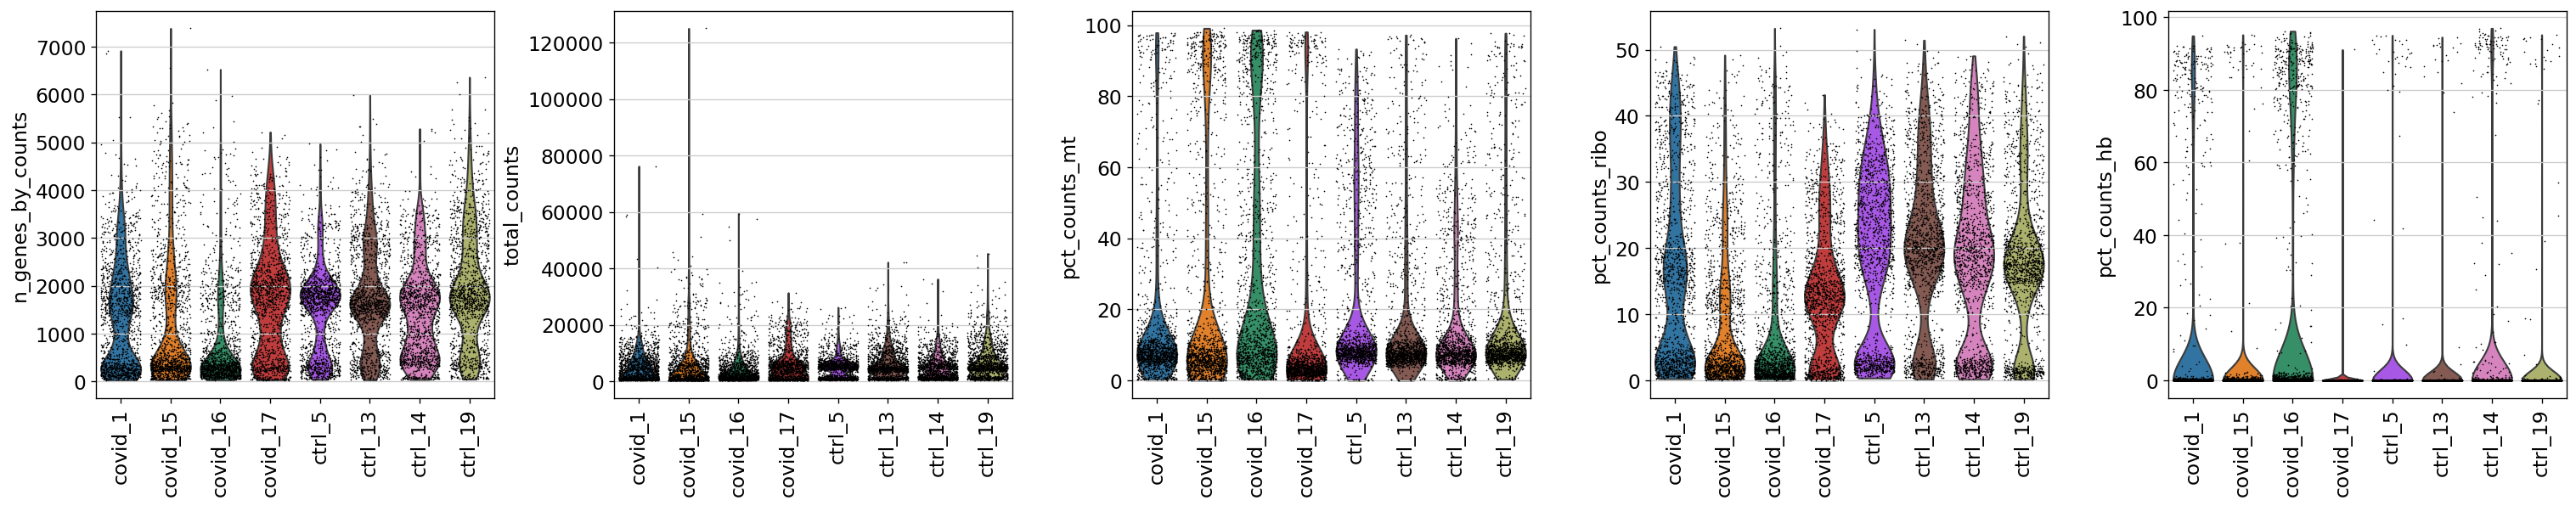

In [39]:
sc.pl.violin(
    adata,
    [
        "n_genes_by_counts",
        "total_counts",
        "pct_counts_mt",
        "pct_counts_ribo",
        "pct_counts_hb",
    ],
    jitter=0.4,
    groupby="sample",
    rotation=90,
    multi_panel=True,
)

위 그림에서 알 수 있듯이 샘플의 품질에 상당한 차이가 있습니다. 예를 들어 `covid_15`와 `covid_16` 샘플은 미토콘드리아 함량이 더 많은 세포를 가지고 있습니다. 반면에 리보솜 유전자의 비율은 다른 샘플보다 적게 검출되었습니다.

다른 시각화 방법으로 QC 측정값을 산점도로 표시해봅니다.

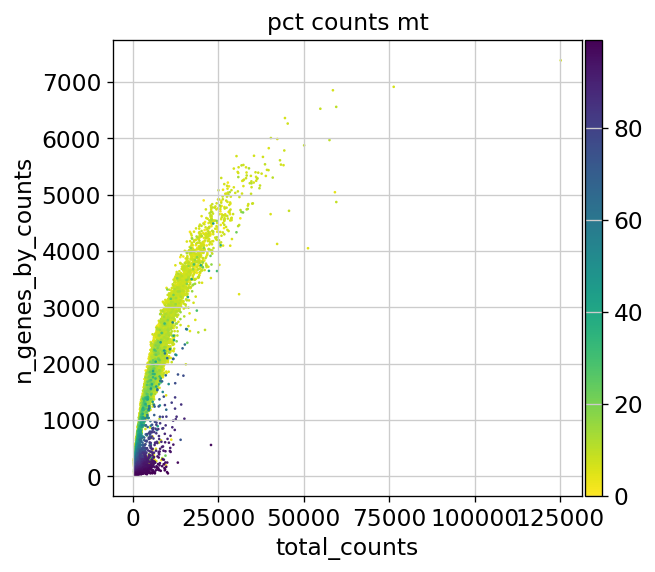

In [40]:
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

위 그림을 보면 미토콘드리아 유전자의 비율이 높은 세포들은 `total_counts`와 `n_genes_by_counts`의 수가 적음을 알 수 있습니다. 이것을 통해 해당 세포들의  상태가 좋지 않다는 것을 유추할 수 있습니다.

따라서 임계값을 설정해 미토콘드리아 유전자가 너무 많이 발현되거나 유전자의 총 개수가 너무 많은 세포들을 제거합니다. 여기서 주의할 점은 가끔 QC 지표가 좋지 않은 것처럼 보이는 세포도 생물학적 의미를 가지고 있을 수 있다는 것입니다. 그러므로 가능하다면 관대한 필터링를 적용하면서 시작하는 게 좋습니다. 
뿐만 아니라 여러 배치가 포함된 데이터셋의 경우 임계값이 배치 간에 매우 크게 달라질 수 있어서 각 배치에 대해서 개별적으로 데이터 품질 관리를 수행해야 합니다.

## 필터링

필터링은 임계값 이하의 데이터들을 제거하는 단계입니다. 데이터의 노이즈를 줄이는 것이라고도 생각할 수 있습니다.

### 검출 기반 필터링

검출 기반 필터링은 판독 횟수가 적은 세포와 최소 지정된 수의 세포에 존재하는 유전자를 필터링하는 것입니다. 일반적으로 200개 이상의 유전자가 검출된 세포와 유전자는 최소 3개 이상의 세포 조건을 많이 사용합니다. 이 값은 사용된 라이브러리 준비 방법에 따라 크게 달라질 수 있다는 점을 염두해 두세요.

In [41]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# 데이터 추가
new_data = {
    "단계": "검출 기반 필터링",
    "바코드의 수": adata.n_obs,
    "유전자의 수": adata.n_vars,
}
df_report = pd.concat([df_report, pd.DataFrame([new_data])], ignore_index=True)
df_report

,단계,바코드의 수,유전자의 수
0,원본,12000,33538
1,검출 기반 필터링,10664,19491


결과를 보니 바코드의 수와 유전자의 수가 동시에 줄어들었다는 것을 알 수 있습니다. 이제 어떤 유전자가 시퀀서에서 많이 읽혔는지도 확인해보죠.

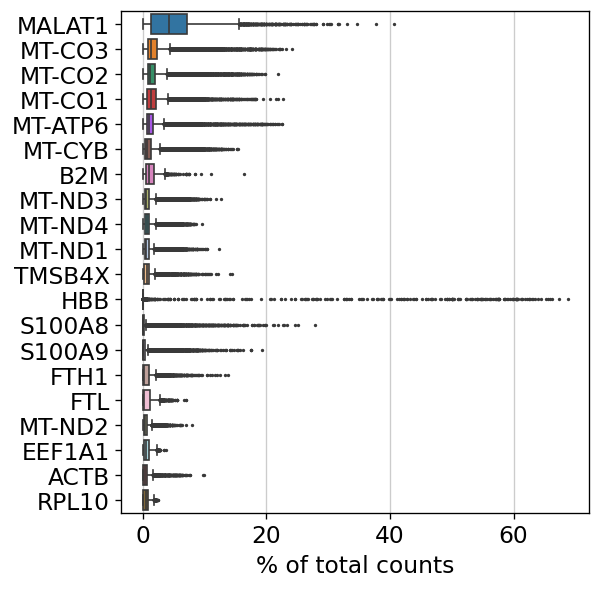

In [42]:
sc.pl.highest_expr_genes(adata, n_top=20)

위 결과를 통해 MALAT1라는 유전자가 아주 많이 읽혔다는 것을 알 수 있으며 다른 상위 유전자들은 미토콘드리아 혹은 리보솜 유전자라는 것을 확인할 수 있습니다. 

> MALAT1은 poly-A 서열을 가지고 있어 scRNA-seq에서 상대적으로 높게 검출되는 것으로 알려져 있습니다.


이제 품질 관리 및 필터링에 중요한 몇가지 유전자에 대한 정보를 모아보겠습니다.

### 미토콘드리아/리보솜 유전자 필터링

미토콘드리아와 리보솜 유전자에 관련된 필터링에 대한 3가지 접근법이 있습니다.

1. 미토콘드리아 유전자 비율이 높고 리보솜 유전자 비율이 낮은 세포를 제거하기.
2. 데이터에서 미토콘드리아 유전자 정보를 제거하고 나머지 유전자 데이터만 사용하기.
3. 데이터를 스케일링을 할 때 `percent_mito`를 회귀시키기.(다만 이 경우 일부 세포에서 유전자 발현 정보가 매우 적게 남을 가능성이 있습니다.)

만약 필터링 후에도 충분한 세포가 남아 있다면 첫번째 방법을 사용하는게 가장 현명한 방법입니다. 이 예제의 경우 대부분의 세포가 미토콘드리아 판독값이 20% 미만이기 때문에 이 값을 임계값으로 사용해 제거하겠습니다. 리보솜 유전자도 마찬가지로 판독률이 5% 미만인 세포는 제거합니다.

In [43]:
# 미토콘드리아 유전자 필터
adata = adata[adata.obs["pct_counts_mt"] < 20, :]

# 리보솜 유전자 필터
adata = adata[adata.obs["pct_counts_ribo"] > 5, :]

# 데이터 추가
new_data = {
    "단계": "MT/Ribo 유전자 비율 필터링",
    "바코드의 수": adata.n_obs,
    "유전자의 수": adata.n_vars,
}
df_report = pd.concat([df_report, pd.DataFrame([new_data])], ignore_index=True)
df_report

,단계,바코드의 수,유전자의 수
0,원본,12000,33538
1,검출 기반 필터링,10664,19491
2,MT/Ribo 유전자 비율 필터링,7431,19491


미토콘드리아와 리보솜 유전자 비율에 대한 필터링으로 바코드의 수가 감소되었다는 것을 알 수 있습니다. 다만 유전자의 수는 그대로입니다. 이제 환자 샘플별로 얼마나 줄었는지 확인해보겠습니다. 처음 바코드의 숫자는 1500개였다는 기억하세요. 

In [44]:
print(adata.obs["sample"].value_counts())

sample
ctrl_13     1173
ctrl_19     1170
covid_17    1101
ctrl_14     1063
ctrl_5      1052
covid_1      900
covid_15     599
covid_16     373
Name: count, dtype: int64


역시 `covid_15, 16` 샘플에서 많은 데이터가 필터링 되었네요.

### 유전자 데이터 필터링

이 예제 데이터에서는 미토콘드리아, 적혈구(HB) 그리고 MALAT1 유전자는 주로 기술적인 문제에 의한 것으로 보입니다. 따라서 해당 유전자에 대한 데이터를 필터링하는것이 현명해 보입니다. 아래는 해당 유전자의 데이터를 제거하는 코드입니다.

In [45]:
malat1 = adata.var_names.str.startswith("MALAT1")
# 미토콘드리아 유전자를 처음에 정의한 이후 다시 정의해야 합니다.
# 발현이 낮은 유전자를 제거하기 전에 전체 오브젝트에서 계산한 값입니다.
mito_genes = adata.var_names.str.startswith("MT-")
hb_genes = adata.var_names.str.contains("^HB[^(P|E|S)]")

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:, keep]

# 행이나 열방향으로 0으로만 존재하는 값이 있는지 확인
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

True
False


위 결과를 보니 유전자를 전혀 포함하지 않는 바코드 데이터가 (`np.any(adata.X.sum(axis=0) == 0)`값이 `True`임으로) 존재하는 것 같네요. 다시 `filter_genes`을 적용하고 확인합니다.

In [46]:
sc.pp.filter_genes(adata, min_cells=3)

# 행이나 열방향으로 0으로만 존재하는 값이 있는지 확인
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

False
False


이제 모두 `False`임으로 문제가 없습니다. 얼마나 많은 유전자 데이터가 필터링 되었는지 확인해봅시다.

In [47]:
# 데이터 추가
new_data = {
    "단계": "특정 유전자 필터링",
    "바코드의 수": adata.n_obs,
    "유전자의 수": adata.n_vars,
}
df_report = pd.concat([df_report, pd.DataFrame([new_data])], ignore_index=True)
df_report

,단계,바코드의 수,유전자의 수
0,원본,12000,33538
1,검출 기반 필터링,10664,19491
2,MT/Ribo 유전자 비율 필터링,7431,19491
3,특정 유전자 필터링,7431,19094


유전자의 수가 약 400개 정도 감소하였습니다.


## 이중체(Doublet) 예측

드롭렛(Droplet)을 만들어 분석하는 scRNA-seq 기술에서 동일한 드롭렛에 여러개의 세포가 들어가는 것은 생각보다 자주 발생하는 문제이며 이중체(Doublet)라고 부릅니다. 10X genomics사의 일반적인 Single Cell 3' Gene Expression v3.1 assay 실험법의 경우 이중체의 비율은 세포의 양에 선형적으로 비례한다고 알려져 있습니다. 아래는 사용자 가이드에 명시된 더블렛의 비율입니다.

| Multiplet Rate (%) | # of Cells Loaded | # of Cells Recovered |
|--------------------|-------------------|----------------------|
| 0.4%              | ~825              | ~500                 |
| 0.8%              | ~1,650            | ~1,000               |
| 2.4%              | ~4,950            | ~3,000               |
| 3.2%              | ~6,300            | ~4,000               |
| 4.0%              | ~8,250            | ~5,000                |
| 5.6%               |~11,550            |~7,000                |
| 6.4%               |~13,200            |~8000                |
| 7.2%               |~14,850            |~9,000                |
| 8.0%               |~16,500            |~10,000               |

예시 데이터셋은 샘플당 약 5,000개의 세포가 있었습니다. 따라서 약 9,000개 세포로 드롭렛을 만들었다고 보여지며 약 4%의 더블렛이 포함되어 있을 것으로 예측됩니다.

하나의 세포에서 검출된 유전자 총 수가 너무 많은 경우는 이중체(Doublet; 2개의 세포가 1개로 분석되는 경우)일 가능성이 있습니다. 그러나 세포 유형 구성에 따라 더 많은 수의 유전자를 가진 세포가 있을 수도 있기 때문에 문제가 복잡해집니다.

이중체를 예측하는 방법에는 여러가지가 있지만 최신 버전 `Scanpy`에는 이중체 감지를 위한 `Scrublet` 패키지가 포함되어 있습니다. `Scrublet`은 관찰된 전사체와 시뮬레이션된 이중체의 KNN을 만들어 이중체를 예측합니다. `sc.pp.scrublet`함수를 사용하면 `doublet_score`와 `predicted_doublet`을 `.obs`에 추가되고 바로 필터링하거나 클러스터링을 하고나서 나중에 `doublet_score`를 사용해 높은 이중점수를 가진 클러스터를 필터링할 수 있습니다.

:::{.callout-note}
더블렛 감지를 위한 다른 방법으로 `scverse` 생태계에는 [DoubletDetection](https://github.com/JonathanShor/DoubletDetection) 및 [SOLO](https://docs.scvi-tools.org/en/stable/user_guide/models/solo.html)가 있습니다. 더 자세한 내용은 [sc-best-practice](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#doublet-detection) 문서에서 확인할 수 있습니다.
:::

아래 코드를 사용해 이중체를 예측하고 감지된 세포의 수를 나타내겠습니다.

In [48]:
sc.pp.scrublet(adata, batch_key="sample")
num_doublet = sum(adata.obs["predicted_doublet"])
print(f"이중체로 감지된 세포의 수: {num_doublet}")

이중체로 감지된 세포의 수: 204


이중체로 예측된 세포에서 더 많은 유전자가 검출되는지 시각화를 통해 살펴보죠.

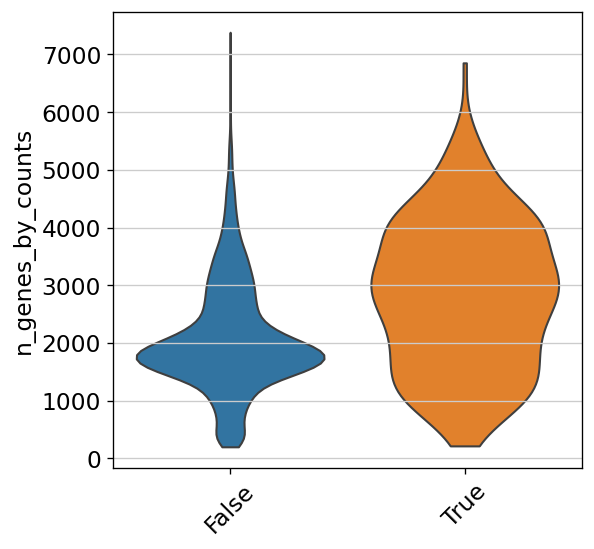

In [49]:
# 참/거짓 대신 싱글렛/더블렛으로 열에 추가합니다.
adata.obs["doublet_info"] = adata.obs["predicted_doublet"].astype(str)
sc.pl.violin(adata, "n_genes_by_counts", size=0, groupby="doublet_info", rotation=45)

확실히 이중체로 예측된 세포들이 `n_genes_by_counts` 값이 높다는 것을 알 수 있습니다. 이제 데이터들을 클러스터링 해서 이중체가 독자적인 클러스터를 형성하는지 확인해보죠. 가장 먼저 유전자 카운트 데이터를 정규화해야 합니다.

In [50]:
# 카운트 데이터 저장
adata.layers["counts"] = adata.X.copy()
# 총 개수 중앙값으로 정규화
sc.pp.normalize_total(adata)
# 로그값으로 변환
sc.pp.log1p(adata)

## 특징(Feature) 선택

사실 scRNA-seq 데이터에 포함된 많은 유전자들은 모든 세포에서 발현량이 높거나 낮아서 생물학적으로 큰 의미는 없고 데이터셋의 차원(크기)을 높이기만 하는 경우가 많습니다. 따라서 특징 선택이라는 단계를 통해서 차이가 있는 유전자들만 남겨서 이후 분석의 계산량을 줄여줍니다. 여기서는 차이가 큰 유전자(highly variable genes) 2000개를 고릅니다.

:::{.callout-note}
예전 버전의 scanpy에서는 특징 선택후 adata객체를 subset하는 과정(`adata = adata[:, adata.var.highly_variable]`)이 필요했지만 최근 버전에는 불필요하게 변경되었습니다.
:::

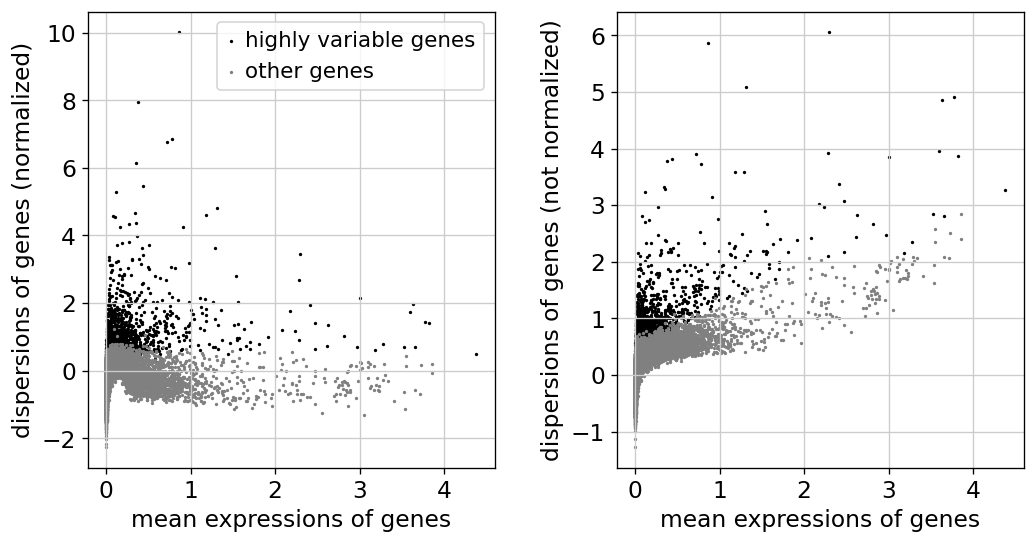

In [51]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata)

In [52]:
# `regress_out` 함수를 사용한 회귀는 데이터셋에 따라 정보가 소실될 수 있습니다.
# 따라서 여기서는 사용하지 않고 아래 코드를 주석 처리하였습니다.
# sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
# sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

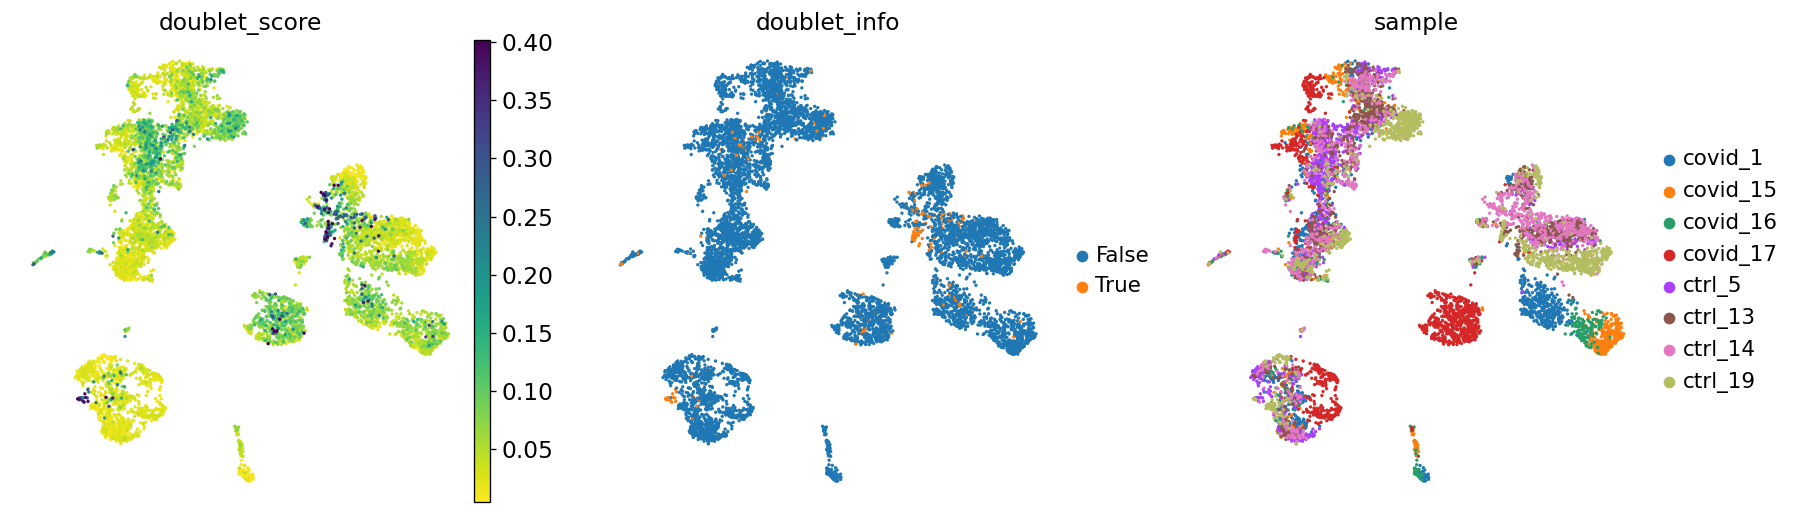

In [53]:
sc.pl.umap(adata, color=["doublet_score", "doublet_info", "sample"])

위 그림을 비교해보면 이중체 점수가 높은 세포들은 샘플 혹은 클러스터와 연관은 없어보입니다. 따라서 `doublet_info`값을 사용해 예상되는 이중체를 모두 제거해 보겠습니다.

In [54]:
adata = adata[adata.obs["doublet_info"] == "False", :]

# 데이터 추가
new_data = {
    "단계": "이중체 필터링",
    "바코드의 수": adata.n_obs,
    "유전자의 수": adata.n_vars,
}
df_report = pd.concat([df_report, pd.DataFrame([new_data])], ignore_index=True)
df_report

,단계,바코드의 수,유전자의 수
0,원본,12000,33538
1,검출 기반 필터링,10664,19491
2,MT/Ribo 유전자 비율 필터링,7431,19491
3,특정 유전자 필터링,7431,19094
4,이중체 필터링,7227,19094


이중체 필터링을 통해 대략적으로 200개의 바코드가 감소하였습니다.

## 성염색체 편향(Bias) 확인

분석 결과에 성염색체에 의한 바이어스가 포함되지 않도록 애초에 scRNA-seq 실험을 계획 할때 단일한 성별로 제한하는 것이 이상적입니다. 그렇지 않다면 아래 같이 추가적인 작업을 통해 성염색체에 대한 편향 확인이 필요합니다.
예를들어 염색체Y(수컷)와 X(주로 여성) 발현량을 샘플별로 파악해보면 샘플의 성별을 쉽게 파악할 수 있습니다. 또한 샘플 메타데이터에 성별 정보가 있다면 예측 결과와 비교해 레이블이 잘못되었는지 확인할 수 있습니다.

유전자의 염색체 위치 정보는 서열 데이터를 alingment할 때 사용한 `gtf`파일에서 가져오는 것이 가장 이상적입니다. 그러나 여기에서는 `Biomart` 도구를 사용해 염색체의 위치 정보를 얻어오는 작업을 해봅니다.

In [55]:
# pybiomart 설치 필요
annot = sc.queries.biomart_annotations(
    "hsapiens",
    [
        "ensembl_gene_id",
        "external_gene_name",
        "start_position",
        "end_position",
        "chromosome_name",
    ],
).set_index("external_gene_name")

# adata.var[annot.columns] = annot

이제 염색체 정보를 얻었으므로 세포당 염색체 Y에서 나온 읽기 비율을 계산할 수 있습니다.

In [56]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])

adata.obs["percent_chrY"] = (
    np.sum(adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100
)

# 플랏을 위한 색상을 추가합니다.
adata.obs["XIST-counts"] = adata.X[:, adata.var_names.str.match("XIST")].toarray()

바이올린 플롯을 그려 `XIST`과 `chrY` 비율을 살펴보죠.

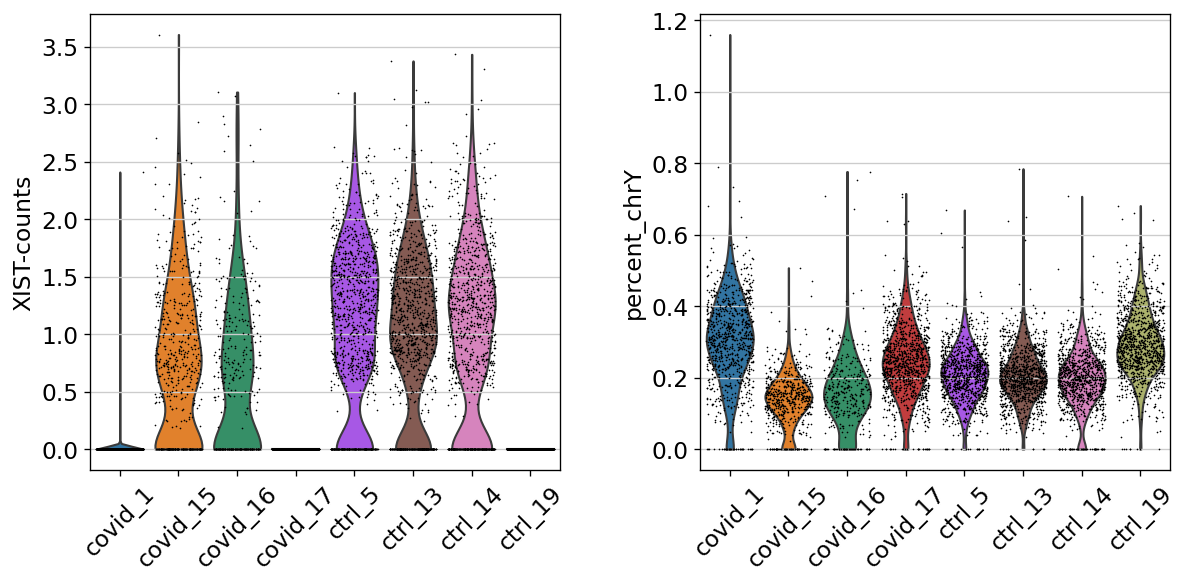

In [57]:
sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4, groupby="sample", rotation=45)

위 그림을 통해 남성의 시료가 3개 여성의 시료가 5개임을 알 수 있습니다. 다행히도 한 쪽에 쏠려있지는 않아서 성염색체에 의한 편향은 무시해도 괜찮을 것 같습니다.

## 세포 주기 예측

이제 세포 주기에 대한 예측을 해봅니다. 세포 주기를 예측하는 원리는 세포 주기 참조 유전자의 목록과 비교해서 유전자의 평균 발현에 대한 차이를 계산하는 것입니다. 따라서 세포 주기 참조 유전자 목록이 필요합니다. 여기에서는 Regev 연구소에서 만든 파일을 사용해 메타데이터에 S 단계에 대한 점수, G2M 단계에 대한 점수, 예측된 세포 주기 단계를 추가하겠습니다.

In [58]:
cell_cycle_genes = [x.strip() for x in open(path_parent + "/regev_lab_cell_cycle_genes.txt")]

# 2개의 목록으로 분할
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(f"포함되어 있는 세포 주기 유전자의 수: {len(cell_cycle_genes)}")

포함되어 있는 세포 주기 유전자의 수: 94


세포 주기를 예측하기 전에 먼저 유전자 카운트 데이터를 정규화해야 합니다. 이미 앞선 코드에서 정규화 및 로그 변환까지 되어 있는 상황임으로 데이터 스케일링만 실행하고 세포 주기를 예측합니다.

In [59]:
sc.pp.scale(adata, max_value=10)
# 세포 주기 예측
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

세포 주기 점수에 대해 시각화를 해봅니다. 일반적인 세포 주기는 다음 3가지로 구분됩니다.

1. G1: 단백질 합성기, 세포의 성장기.
2. S: DNA 복제기, DNA의 양이 두배가 된다.
3. G2: 세포 분열 준비기

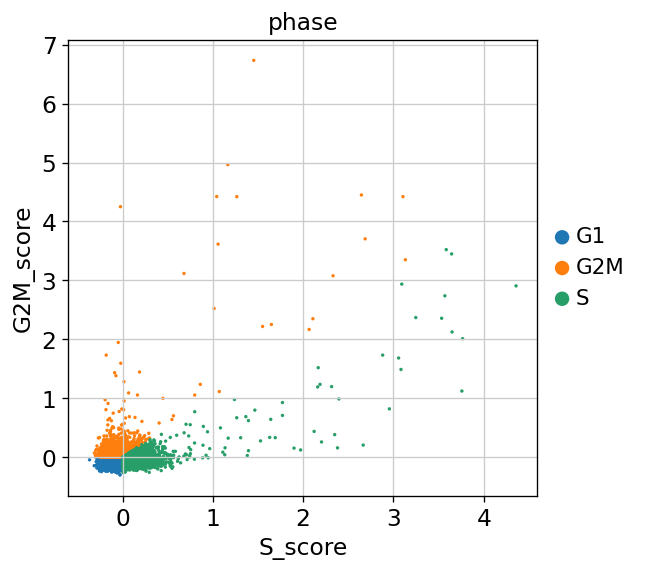

In [60]:
# 바이올린 플랏
# sc.pl.violin(adata, ["S_score", "G2M_score"], jitter=0.4, groupby="sample", rotation=60)
# 산포도 플랏
sc.pl.scatter(adata, x="S_score", y="G2M_score", color="phase")

일반적인 사람 세포들은 G1기가 가장 긴것으로 알려져있습니다. 그러나 예시 데이터셋에는 G1기의 세포가 상대적으로 적어 보입니다. 이것은 세포 주기 예측의 기본 임계값이 `0`으로 고정되어 있기 때문으로 임계값 수정이 필요하다고 말할 수 있습니다. 따라서 세포 주기 예측은 결과 해석을 할 때 항상 주의해야 합니다.

이제 QC과정을 거치면서 제거된 데이터들의 비율을 계산해보죠. 이것을 통해 어떤 단계를 다시 조정하는 것이 좋을지 판단할 수 있습니다.

In [61]:
# 첫 번째 행의 바코드 수와 유전자 수 값 저장
initial_num_barcode = df_report.loc[0, "바코드의 수"]
initial_num_gene = df_report.loc[0, "유전자의 수"]

# 비율 계산 후 새로운 열 추가
df_report["바코드 필터 비율"] = df_report["바코드의 수"] / initial_num_barcode
df_report["유전자 필터 비율"] = df_report["유전자의 수"] / initial_num_gene

df_report

,단계,바코드의 수,유전자의 수,바코드 필터 비율,유전자 필터 비율
0,원본,12000,33538,1.0,1.0
1,검출 기반 필터링,10664,19491,0.888667,0.581162
2,MT/Ribo 유전자 비율 필터링,7431,19491,0.61925,0.581162
3,특정 유전자 필터링,7431,19094,0.61925,0.569324
4,이중체 필터링,7227,19094,0.60225,0.569324


위를 통해 검출 기반 필터링과 유전자 비율 필터링에서 많은 데이터가 제거되었다는 것을 알 수 있습니다. 따라서 다시 시작한다면 그 쪽의 매개변수를 조절해보는 것이 좋겠습니다.

## 데이터 정리하기

파일을 저장하기전 전체 파일의 크기를 줄이기 위해 필요하지 않아 보이는 데이터를 제거합니다.

In [62]:
# 정규화 된 값을 원본 Count값으로 다시 되돌리기
adata.X = adata.layers["counts"].copy()
del adata.layers["counts"]

# 필요한 obs와 var 컬럼 지정
required_obs_columns = ["type", "sample", "batch"]  # 실제 필요한 열로 대체
required_var_columns = ["gene_ids", "feature_types", "genome"]  # 실제 필요한 열로 대체

# obs에서 필요한 열만 남기고 삭제
obs_columns_to_drop = [col for col in adata.obs.columns if col not in required_obs_columns]
adata.obs.drop(columns=obs_columns_to_drop, inplace=True)

# var에서 필요한 열만 남기고 삭제
var_columns_to_drop = [col for col in adata.var.columns if col not in required_var_columns]
adata.var.drop(columns=var_columns_to_drop, inplace=True)

# uns, obsm, varm, obsp 속성 삭제
adata.uns = {}
adata.obsm = {}
adata.varm = {}
adata.obsp = {}

# 데이터 확인
print(adata)

AnnData object with n_obs × n_vars = 7227 × 19094
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'


## 데이터 저장

마지막으로 QC된 데이터를 저장해 이후 분석에 사용합니다. Scanpy는 기본적으로 `h5ad`형식으로 파일을 저장합니다.

In [63]:
adata.write_h5ad("./output/covid/results/scanpy_covid_qc.h5ad", compression="gzip")

# 마치며

지금까지 `scanpy`를 사용해 scRNA seq 데이터 QC과정을 알아보았습니다. 이 과정은 간단해 보이지만 분석을 하다보면 반복적으로 되돌아와서 다시 진행하는 경우가 많습니다. 특히나 시간이 많이 지난 상황에서 다시 하려면 쉽지 않죠. 그러니 가능하면 자세한 기록과 주석을 남겨두시는 것을 추천합니다.